# Import Data and Packages

In [1]:
# Import packages

# General Use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

#Utilities
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# Specific to Time Series Modeling
import dateutil
from dateutil.relativedelta import relativedelta

#XGBoost
import xgboost as xgb

# Model Scoring/Data Prep
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
filepath = "C:\\Users\\t_zim\\Desktop\\WeatherProject\\data\\"

df_2018 = pd.read_csv(str(filepath)+'2018.csv')
df_2019 = pd.read_csv(str(filepath)+'2019.csv')
df_2020 = pd.read_csv(str(filepath)+'2020.csv')
df_2021 = pd.read_csv(str(filepath)+'2021.csv')
allDates = pd.read_csv(str(filepath)+'allDates.csv')

# Define Functions

In [3]:
# # # # Date Slicer Functions # # # #

# Convert String to DateTime
def convert_to_string():
    pass

# Ability to slice data to for specific start date forward
def date_slicer_start(data, start_date):
    data['Date'] = pd.to_datetime(data['Date'])
    sliced_df = data[~(data['Date'] < start_date)]
    return sliced_df

# Ability to slice data to for specific end date backward
def date_slicer_end(data, end_date):
    data['Date'] = pd.to_datetime(data['Date'])
    sliced_df = data[(data['Date'] < end_date)]
    return sliced_df

# Ability to slice data to focus on specific window
def date_slicer_window(data, start_date, end_date):
    data['Date'] = pd.to_datetime(data['Date'])
    sliced_df = data[~(data['Date'] < start_date) & (data['Date'] < end_date)]
    return sliced_df

def date_slicer_range(data, start_date, integer):
    pass
    end_date = start_date + integer
    data['Date'] = pd.to_datetime(data['Date'])
    sliced_df = data[~(data['Date'] < start_date) & (data['Date'] < end_date)]
    return sliced_df

# Split to train/test using a point in time instead of random sampling
def train_test_split_dates(X,y,split_date):
    # Recast as datetime
    X['Date'] = pd.to_datetime(X['Date'])
    y['Date'] = pd.to_datetime(y['Date'])
    # Training set
    X_train = X[~(X['Date'] < split_date)]
    y_train = y[~(y['Date'] < split_date)]
    # Test set
    X_test = X[(X['Date'] < split_date)]
    y_test = y[(y['Date'] < split_date)]
    return X_train, X_test, y_train, y_test

In [4]:
# # # # Utility Functions # # # #


# # # # General Use # # # #

# Set the index to the date column
def date_index(data):
    data = data.set_index('Date')
    return data

# Convert a column to datetime.
def datetime_datatype(data):
    data['Date'] = pd.to_datetime(data['Date'])
    return data

# # # # Pre Processing Before Model # # # # 

# Allow for differencing during preprocessing to visually check ACF plot (see appendix)
def differencing_lag1(lag=1):
    pass

def df_constructor_input():
    pass

def change_value_column():
    pass


In [5]:
# # # # XGBoost Functions # # # #

# # # Data Prep # # # 

# Split to train/test using a point in time instead of random sampling
def train_test_split_dates(X,y,split_date):
    # Recast as datetime
    X['Date'] = pd.to_datetime(X['Date'])
    y['Date'] = pd.to_datetime(y['Date'])
    # Training set
    X_train = X[(X['Date'] < split_date)]
    y_train = y[(y['Date'] < split_date)]
    # Test set
    X_test = X[~(X['Date'] < split_date)]
    y_test = y[~(y['Date'] < split_date)]
    return X_train, X_test, y_train, y_test

def remove_date_column(X_train, X_test, y_train, y_test):
    del X_train['Date']
    del y_train['Date']
    del X_test['Date']
    del y_test['Date']
    return X_train, X_test, y_train, y_test


# # # Post Modeling # # # 

# Evaluation function calculating a number of helpful error metrics for Continuous Models
def evaluate_Continuous(model, test_features, test_labels):
    predictions = model.predict(test_features)

    r2 = r2_score(y_pred=predictions, y_true=test_labels)
    MSE = mean_squared_error(y_pred=predictions, y_true=test_labels)
    RMSE = sqrt(MSE)

    print('Model Performance')
    print('R2 = {:0.2f}%.'.format(r2))
    print('MSE = {:0.2f}.'.format(MSE))
    print('RMSE = {:0.2f}.'.format(RMSE))

    return [r2, MSE, RMSE, predictions]

# Build a list of dates to merge with predictions array [Days]
def create_dates_days(data, points_to_predict):
    last_date = data.index[-1]
    predicted_dates = []
    for _ in range(points_to_predict):
        next_date = last_date + relativedelta(days=1)
        predicted_dates.append(next_date)
        last_date = next_date
    return predicted_dates

# Build a list of dates to merge with predictions array [Weeks]
def create_dates_weeks(data, points_to_predict):
    last_date = data.index[-1]
    predicted_dates = []
    for _ in range(points_to_predict):
        next_date = last_date + relativedelta(weeks=1)
        predicted_dates.append(next_date)
        last_date = next_date
    return predicted_dates

# Build a list of dates to merge with predictions array [Months]
def create_dates_months(data, points_to_predict):
    predicted_dates = []
    last_date = data.index[-1]
    for _ in range(points_to_predict):
        next_date = last_date + relativedelta(months=1)
        predicted_dates.append(next_date)
        last_date = next_date
    return predicted_dates

# Construct the prediction array as DF with Date column
def df_constructor_predictions(date, predicted):
    predictions = pd.DataFrame(date)
    predictions['predicted'] = predicted
    predictions.columns = ['Date','Prediction']
    return predictions

# Temperature

In [6]:
df = allDates

## Feature Engineering/ Initial Data Prep

In [7]:
# Pre Modeling Date Slicing (if necessary. NOT Train/Test yet)
# Ability to slice data to for specific start date forward
start_date = '2018-01-01'
df = date_slicer_start(df, start_date)

## Temperature Data Final Preprocessing

In [8]:
# Column Parking Lot (columns taken out of model consideration)

#'Max_Temp', 'Min_Temp',
#'Max_DewPoint','Min_DewPoint', 
#'Max_Pressure', 'Avg_Pressure', 
# 'Max_Humidity', 'Min_Humidity'
# 'Avg_Windspeed', 'Max_Windspeed', 

In [9]:
# X Variables
independent_keep = [ 'Avg_DewPoint','Avg_Humidity','Min_Windspeed','Min_Pressure', 'Precipitation','Date']
# Y Variable and values
target = ['Avg_Temp','Date']
# Categorical is all columns that need to be one hot encoded
categorical_variables = []
# Continuous could be binary as well
continuous_variables = independent_keep

In [10]:
# Prepare data for Modeling

# Remove missing values
df = df.fillna(0)
df = df.reset_index(drop=True)

#Subset Data by Columns to Keep and Split up X and y matrices
X = df[independent_keep]
y = df[target]

# One-hot encode categorical variables
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X[categorical_variables])
X_ohed = one_hot_encoder.transform(X[categorical_variables]).toarray()
X_ohed = pd.DataFrame(X_ohed,columns=one_hot_encoder.get_feature_names(categorical_variables))

# Merge one-hot encoded categorical variables with continuous variables
X = pd.concat([X[continuous_variables], X_ohed], axis=1)

In [11]:
# split into train / test sets
split_date = '2020-06-30'

# Split dataset into training and test on a specified date
X_train, X_test, y_train, y_test = train_test_split_dates(X,y,split_date)

# Save a list of the dates for the test set
dates_for_test_set = y_test['Date']


# Remove Date column for modeling
X_train, X_test, y_train, y_test = remove_date_column(X_train, X_test, y_train, y_test)

In [12]:
# Full Parameter Grid
param_grid = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }


## Temperature Training

In [13]:
# XGBoost Modeling.  Cross fold validation and grid search to find best parameters.

xgboost_model = xgb.XGBRegressor()

# Save column names for future visualization
independent_columns = X_test.columns

# Initialize parameter grid for XGBoost. Shortened for brevity
param_grid = {
     "eta"    : [0.30] ,
     "max_depth"        : [ 3, 4, 5],
     "min_child_weight" : [ 1, 3],
     "gamma"            : [0.4 ],
     "colsample_bytree" : [0.7 ]
     }


# Initialize grid_search.  If it takes too long, lower the crossvalidation number
grid_search = GridSearchCV(estimator=xgboost_model,
                           param_grid=param_grid,  # parameters to be tuned
                           cv=2,
                           n_jobs=-1,  # -1 means use all available cores
                           verbose=2,
                           )

# Perform CV search over grid of hyperparameters
grid_search.fit(X_train, y_train)

print("Best CV accuracy: {}, with parameters: {}".format(
    grid_search.best_score_, grid_search.best_params_))

cv_best_model = grid_search.best_estimator_
r2, MSE, RMSE, predictions = evaluate_Continuous(cv_best_model, X_test, y_test)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    5.0s remaining:   10.0s


Best CV accuracy: 0.981437481091608, with parameters: {'colsample_bytree': 0.7, 'eta': 0.3, 'gamma': 0.4, 'max_depth': 3, 'min_child_weight': 1}
Model Performance
R2 = 0.93%.
MSE = 12.64.
RMSE = 3.56.


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.5s finished


## Temperature Modeling Visualization

In [14]:
# Prepare Prediction, Ground Truth, and Metrics

# Create DF
prediction_df = pd.DataFrame()
# Handle Dates for Index
prediction_df['Date'] = dates_for_test_set
prediction_df = datetime_datatype(prediction_df)
prediction_df = date_index(prediction_df)
# Add Predictions to DF
prediction_df[target[0]] = predictions.tolist()
# Add Ground Truth to DF
prediction_df['ground_truth'] = y_test.iloc[:,0].tolist()
# Compute Residuals
prediction_df['Residuals'] = prediction_df.iloc[:,0] - prediction_df.iloc[:,1]

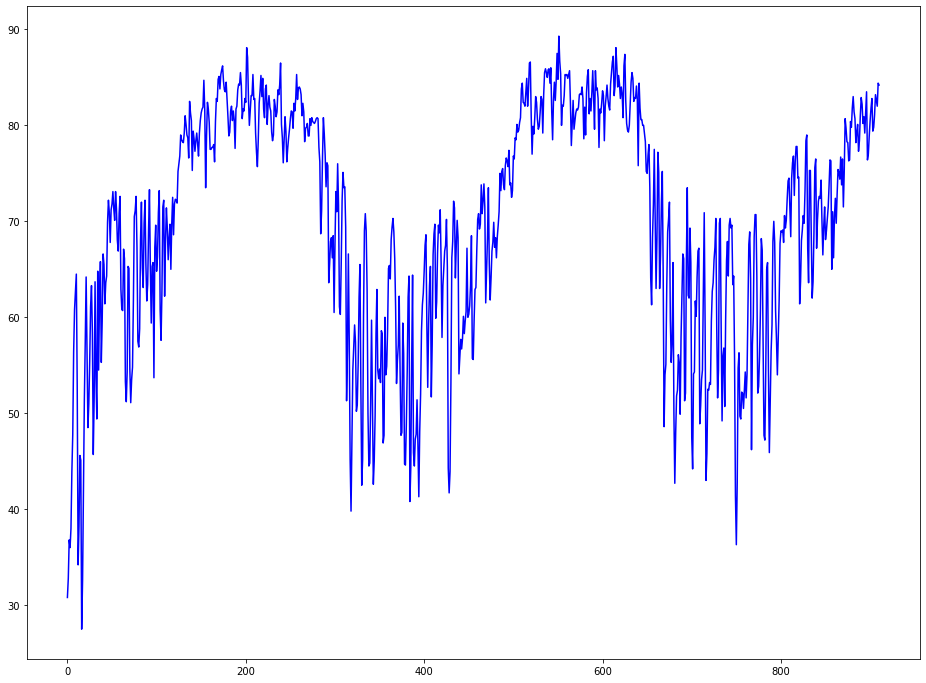

In [15]:
# Plot training set
fig, axes = plt.subplots(1, 1, figsize=(16, 12))
axes.plot(y_train, color="blue")

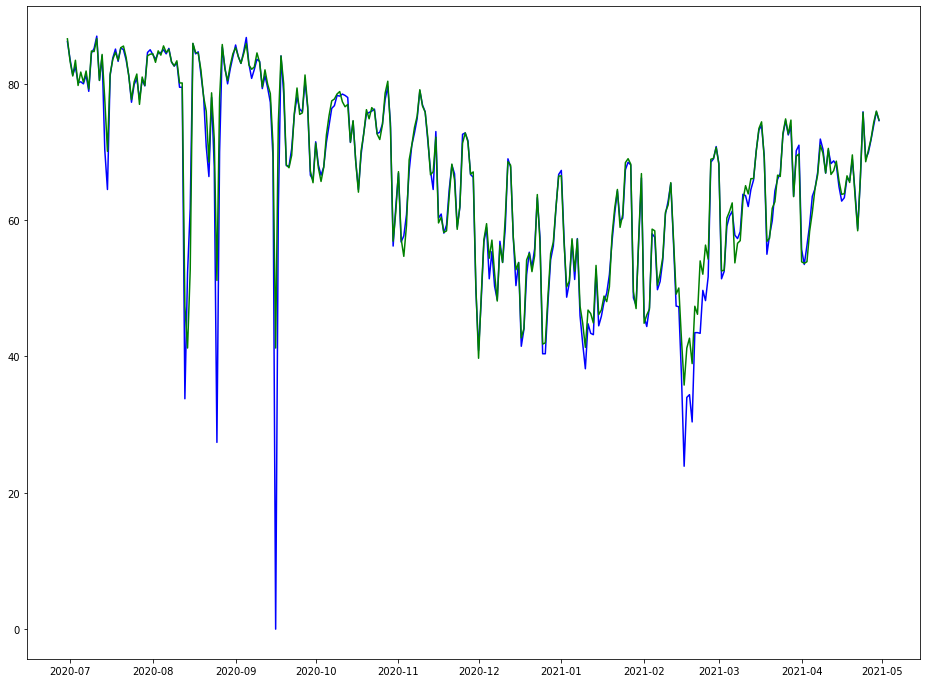

In [16]:
# Plot ground_truth vs prediction on graph
fig, axes = plt.subplots(1, 1, figsize=(16, 12))
axes.plot(prediction_df['ground_truth'], color="blue")
axes.plot(prediction_df[target[0]], color="green")

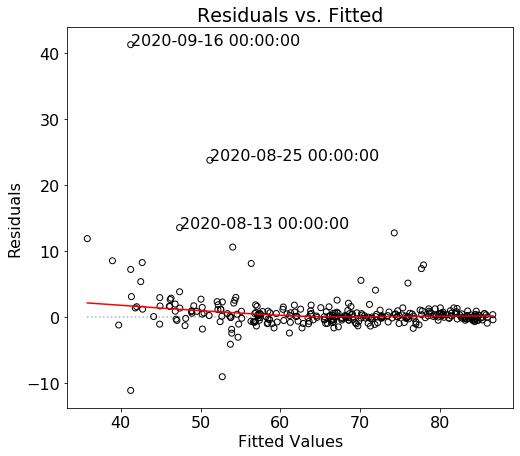

In [17]:
#Residuals vs Fitted Plot
smoothed = lowess(prediction_df['Residuals'],prediction_df[target[0]])
top3 = abs(prediction_df['Residuals']).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(prediction_df[target[0]], prediction_df['Residuals'], edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(prediction_df[target[0]]),max(prediction_df[target[0]])],[0,0],color = 'k',linestyle = ':', alpha = .3)

#Annotate the max and min values
for i in top3.index:
    ax.annotate(i,xy=(prediction_df[target[0]][i],prediction_df['Residuals'][i]))
    
    
# In this case, you only learn what the predictions look like to potentially see outliers, or trends.
# Heteroskedasticity is not an assumption to check
# Does not show how a particular observation fell in the tree.

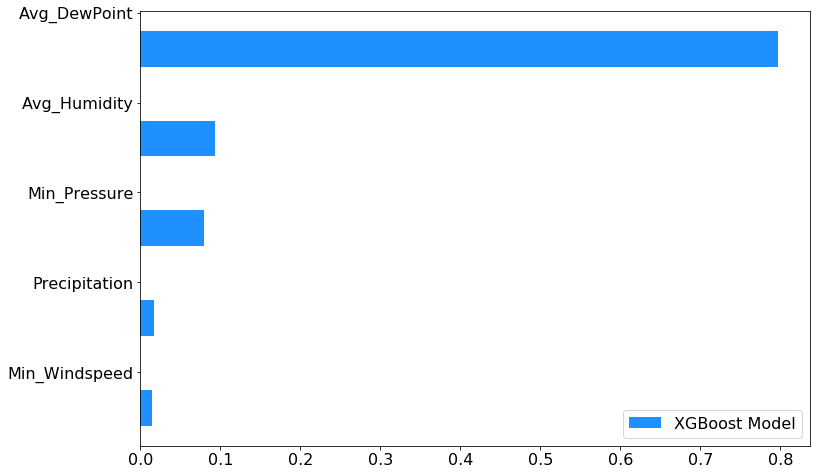

In [18]:
# Variable Importance Bar Graph

feature_importance=pd.DataFrame({'xgboost_model':cv_best_model.feature_importances_},index=X_train.columns)
feature_importance.sort_values(by='xgboost_model',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(12,8))
rfc_feature=ax.barh(index,feature_importance['xgboost_model'],0.4,color='dodgerblue',label='XGBoost Model')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)

ax.legend()
plt.show()

In [19]:
#msno.matrix(submission)

# Precipitation

## Precipitation Data Preprocessing

## Precipitation Modeling

## Precipitation Modeling Visualization